# Environmental parameter: $\Sigma_5$ (or $\delta_5$)

According to [Cooper et al. 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.383.1058C/abstract), the $\delta_5$ parameter, or overdensity calculated by finding normalized surface density to the fifth nearest neighbor (within $\pm$1,000 km/s), is a good way to parameterize environment.

We can restrict the $\alpha.40$ catalog to $z < 0.05$ ish, which allows us to get a high-fidelity sample of $\alpha.40$ neighbors to within $z < .053$ from the [NSA catalog](http://nsatlas.org/data).

In [1]:
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import match_coordinates_sky, SkyCoord
import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tqdm

%matplotlib inline

In [12]:
a40 = pd.read_csv('../data/a40.datafile1.csv', index_col='AGCNr')

# nsa = fits.getdata('../../dusty-halos/data/nsa_v0_1_2.fits')
nsa = fits.getdata('../data/nsa_v1_0_1.fits')

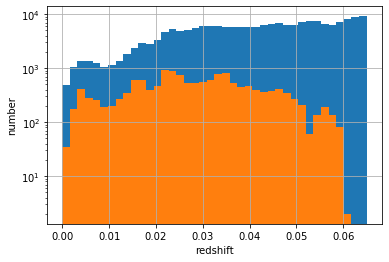

In [5]:
plt.hist(nsa['Z'], bins=40, range=[0, .065])
(a40.Dist * 70 / 3e5).hist(bins=40, range=[0, .065])
plt.yscale('log')
plt.xlabel('redshift')
plt.ylabel('number');

In [13]:
nsa = nsa[nsa['Z'] < 0.07]

In [14]:
a40.sample(3)

,Name,RAdeg_HI,Decdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,errW50,HIflux,errflux,SNR,RMS,Dist,logMsun,HIcode,OCcode,NoteFlag
AGCNr,,,,,,,,,,,,,,,,,
733590,NaN,228.02457,25.63056,228.01917,25.62917,6710,198,8,1.06,0.08,7.3,2.30,97.9,9.38,1,I,NaN
242486,NaN,215.18750,4.31056,215.19708,4.29833,8076,108,7,0.98,0.07,8.7,2.41,118.9,9.51,1,P,*
202262,FGC125a,159.36751,12.39528,159.36958,12.39611,1330,59,4,1.98,0.06,26.0,2.19,22.0,8.35,1,P,*


In [16]:
# get all things more than 10 Mpc away
a40_coords = a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)][['RAdeg_OC', 'DECdeg_OC']]
a40_vel = a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)]['Dist'] * 70 


In [17]:
a40_coords = SkyCoord(ra=a40_coords.RAdeg_OC, dec=a40_coords.DECdeg_OC, unit=u.deg)
nsa_coords = SkyCoord(ra=nsa['RA'], dec=nsa['DEC'], unit=u.deg)

In [18]:
c = FlatLambdaCDM(H0=70, Om0=0.3)

In [19]:
match_coordinates_sky(a40_coords[0], nsa_coords, nthneighbor=5)[1][0].rad

0.004878163038976902

In [20]:
# physical distance to fifth nearest neighbor
D_5 = []

for ra_dec, vel in tqdm.tqdm_notebook(zip(a40_coords, a40_vel), total=len(a40_vel)):
    vel_range = (nsa['z'] - 1000 < vel / 3e5) & (nsa['z'] + 1000 > vel / 3e5)
    ang = match_coordinates_sky(ra_dec, nsa_coords[vel_range], nthneighbor=5)[1][0].rad
    D_5.append(c.angular_diameter_distance(vel / 3e5) * ang)


In [33]:
(Sigma_5 <= 0).sum()

0

In [34]:
# Sigma_5 (in units of Mpc^-2)
Sigma_5 = 3 / (np.pi * np.array([D.value for D in D_5])**2)

log_S5 = np.log10(Sigma_5)


In [47]:
# mean trend with redshift

def redshift_trend(xs, zs, dz=0.02, zi=0, zf=0.07, zstep=0.002):
    """Given two arrays `xs` and `zs` with same length, find how 
    median `xs` varies with `zs` (redshifts) over a boxcar window 
    of size `dz`.
    
    The bounds are `zi` and `zf`, and step sizes are `zstep`. 
    """ 
    
    return np.array([np.nanmedian(xs[(zs > z0 - dz/2) & (zs < z0 + dz/2)]) for z0 in np.arange(zi, zf, zstep)])
        
median_S5 = redshift_trend(Sigma_5, a40_vel / 3e5)

**Note that this same median trend should be used for xGASS too!**

In [62]:
np.save('../data/NSA_median_sigma_5', median_S5, )

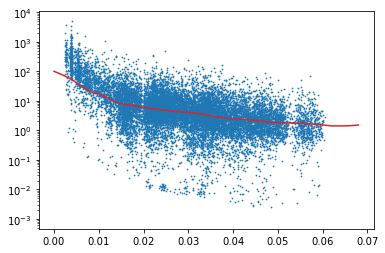

In [48]:
plt.scatter(a40_vel/3e5, Sigma_5, s=0.5, )
plt.plot(np.arange(0, 0.07, 0.002), median_S5, c='C3')

plt.yscale('log')

In [50]:
# Now we want to get the red line's value at every blue point (not necessarily in order)
interpolated_median_S5 = np.interp(
    a40_vel / 3e5,                     # redshifts at which we want to evaluate
    np.arange(0, 0.07, 0.002),          # redshifts (independent var)
    median_S5                          # Sigma_5 trend (dependent var)
)

# normalize by redshift (1 + delta_5)
delta_5 = Sigma_5 / interpolated_median_S5

Text(0.5, 0, 'redshift')

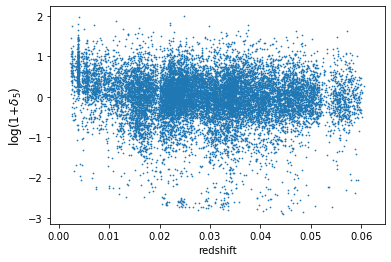

In [56]:
plt.scatter(a40_vel/3e5, np.log10(delta_5), s=0.5)
plt.ylabel(r'log(1+$\delta_5$)', fontsize=12)
plt.xlabel('redshift')

~~Note that we can later make spatial cuts to avoid edge effects.~~

In [55]:
# overdensity = pd.DataFrame({'Sigma_5': Sigma_5.flatten(), 'AGCNr': np.array(a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)].index)})
# overdensity.to_csv('../data/a.40-Sigma_5.csv')

In [57]:
overdensity = pd.DataFrame({'delta_5': delta_5.flatten(), 'AGCNr': np.array(a40[a40.RAdeg_OC.notnull() & (a40.Dist > 10)].index)})
overdensity.to_csv('../data/a.40-delta_5.csv')

In [58]:
overdensity = pd.read_csv('../data/a.40-delta_5.csv')

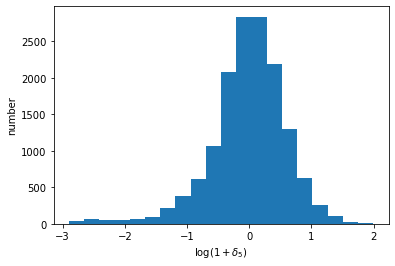

In [61]:
a40_log_d5 = np.log10(overdensity.delta_5)

plt.hist(a40_log_d5, bins=20)
plt.xlabel(r'log($1+\delta_5$)')
plt.ylabel('number');

# Same thing with xGASS

In [63]:
xgass = pd.read_csv('../data/xGASS_representative_sample.csv')

In [64]:
xgass_coords = SkyCoord(ra=xgass.RA, dec=xgass.DEC, unit=u.deg)
xgass_z = xgass.zSDSS

In [65]:
D_5 = []

for ra_dec, z in tqdm.tqdm_notebook(zip(xgass_coords, xgass_z), total=len(xgass_z)):
    vel_range = (nsa['z'] - 1000/3e5 < z) & (nsa['z'] + 1000/3e5 > z)
    ang = match_coordinates_sky(ra_dec, nsa_coords[vel_range], nthneighbor=5)[1][0].rad
    D_5.append(c.angular_diameter_distance(z) * ang)

In [66]:
xgass_Sigma_5 = 3 / (np.pi * np.array([D.value for D in D_5])**2)

In [67]:
xgass_interp_median_S5 = np.interp(
    xgass_z,                   
    np.arange(0, 0.07, 0.002), 
    median_S5                  
)

In [68]:
xgass_delta_5 = xgass_Sigma_5 / xgass_interp_median_S5

In [69]:
overdensity = pd.DataFrame({'delta_5': xgass_delta_5.flatten(), 'GASS': xgass.GASS})
overdensity.set_index('GASS', inplace=True, drop=True)
overdensity.to_csv('../data/xGASS-delta_5.csv', )

In [70]:
overdensity = pd.read_csv('../data/xGASS-delta_5.csv', )
xgass_log_d5 = np.log10(overdensity.delta_5)


# Point density

In [71]:
H, xedges, yedges = np.histogram2d(nsa_coords.ra, nsa_coords.dec, bins=(300, 300))

/home/john/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


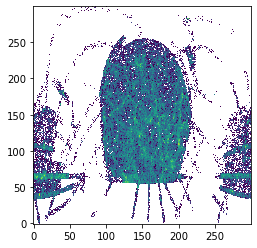

In [72]:
plt.imshow(np.log10(H.T), origin='lower')

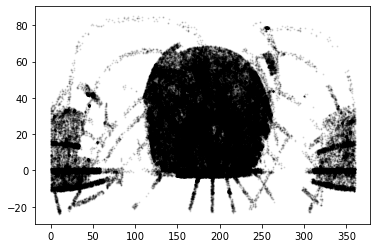

In [73]:
plt.scatter(nsa_coords.ra, nsa_coords.dec, s=1, c='k', alpha=0.1)

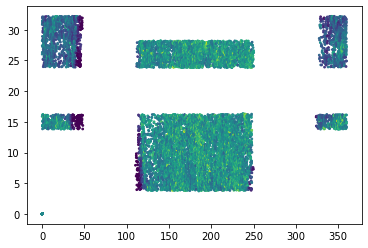

In [74]:
plt.scatter(a40_coords.ra, a40_coords.dec, s=3, c=a40_log_d5, vmin=-2, vmax=2)

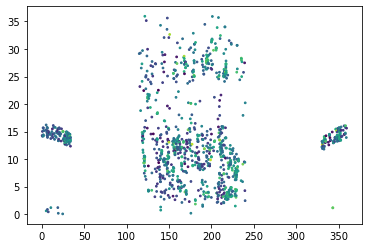

In [75]:
plt.scatter(xgass_coords.ra, xgass_coords.dec, s=3, c=xgass_log_d5, vmin=-2, vmax=2)

# Looking at correlations between other properties and low- and high-$\Sigma_5$

In [76]:
a40 = (pd.read_csv("../data/a40-SDSS_gas-frac.csv")
        .join(pd.read_csv("../data/a.40-delta_5.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_a40')
        .join(pd.read_csv("../data/a40.datafile3.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_sdss')
)

In [77]:
a40.columns

Index(['Unnamed: 0', 'AGCNr', 'logfgas', 'Unnamed: 0_a40', 'delta_5', 'HIcode',
       'OCcode', 'PhotoObjID', 'SpectObjID', 'rmodelmag', 'uminusr', 'z_sdss',
       'z_err'],
      dtype='object')

Text(0.5, 0, 'z_sdss')

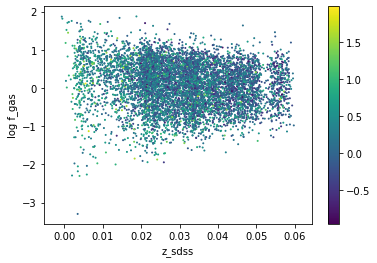

In [78]:
plt.scatter(a40.z_sdss, a40.logfgas, c=np.log10(a40.delta_5), cmap='viridis', s=1)
plt.colorbar();
plt.ylabel('log f_gas')
plt.xlabel('z_sdss')

Text(0.5, 0, 'log 1+d_5')

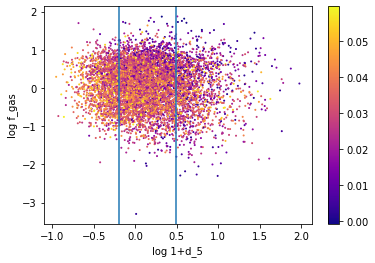

In [80]:
plt.scatter(np.log10(a40.delta_5), a40.logfgas, c=a40.z_sdss, cmap='plasma', s=1)
plt.colorbar();

plt.axvline(x=np.nanquantile(np.log10(a40.delta_5), 0.2))
plt.axvline(x=np.nanquantile(np.log10(a40.delta_5), 0.8))

plt.ylabel('log f_gas')
plt.xlabel('log 1+d_5')

In [81]:
underdense = a40.delta_5 < np.nanquantile(a40.delta_5, 0.2)
overdense = a40.delta_5 > np.nanquantile(a40.delta_5, 0.8)

print(f'q < 0.2 log gas mass fraction scatter: {np.std(a40[underdense].logfgas):.4f}')
print(f'q > 0.8 log gas mass fraction scatter: {np.std(a40[overdense].logfgas):.4f}')
print(f'0.2 < q < 0.8 log gas mass fraction scatter: {np.std(a40[~underdense & ~underdense].logfgas):.4f}')

q < 0.2 log gas mass fraction scatter: 0.5241
q > 0.8 log gas mass fraction scatter: 0.6702
0.2 < q < 0.8 log gas mass fraction scatter: 0.6109


Text(0.5, 0, 'z_sdss')

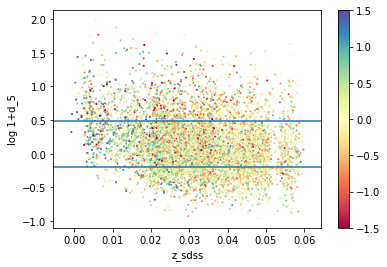

In [82]:
plt.scatter(a40.z_sdss, np.log10(a40.delta_5), c=a40.logfgas, cmap='Spectral', s=1, vmin=-1.5, vmax=1.5)
plt.colorbar();

plt.axhline(y=np.nanquantile(np.log10(a40.delta_5), 0.2))
plt.axhline(y=np.nanquantile(np.log10(a40.delta_5), 0.8))

plt.ylabel('log 1+d_5')
plt.xlabel('z_sdss')

**Good! All trends are removed**

# Figures summarizing all findings

~~**Note that I'm using $\Sigma_5$ which is just the un-normalized version of $\delta_5$**. This allows me to compare xGASS and ALFALFA.~~

Since I've normalized both xGASS and ALFALFA using the same NSA environmental trend, we can compare the two.

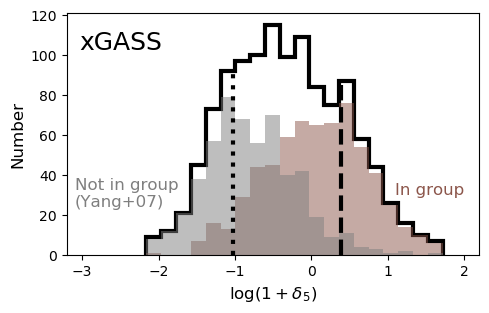

In [100]:
overdensity = pd.read_csv('../data/xGASS-delta_5.csv', )

plt.figure(figsize=(5, 3), dpi=100)


_, xgass_bins, _ = plt.hist(np.log10(overdensity.delta_5), bins=20, label='xGASS', histtype='step', lw=3, color='k')


plt.vlines(np.quantile(np.log10(overdensity.delta_5), 0.2), 1e-5, 93, ls=':', lw=3, color='k0')
plt.vlines(np.quantile(np.log10(overdensity.delta_5), 0.8), 1e-5, 85, ls='--', lw=3, color='k')


plt.hist(np.log10(overdensity.delta_5)[xgass.env_code_B != 1], bins=xgass_bins, color='C5', lw=2, alpha=0.5)
plt.hist(np.log10(overdensity.delta_5)[xgass.env_code_B == 1], bins=xgass_bins, color='C7', lw=2, alpha=0.5)

plt.xlabel(r'log($1+\delta_5$)', fontsize=12)
plt.ylabel('Number', fontsize=12);

plt.xlim(-3.2, 2.2)
# plt.ylim(0, 10)

plt.text(-3.1, 24, 'Not in group\n(Yang+07)', fontsize=12, color='C7')
plt.text(1.1, 30, 'In group', fontsize=12, color='C5')

# plt.title('xGASS')
# plt.legend(fontsize=10);

plt.text(0.03, 0.85, r'xGASS', transform=plt.gca().transAxes, fontsize=18)

plt.subplots_adjust(left=0.15, bottom=0.17, right=0.975, top=0.975)

plt.savefig(f'../results/figures/xGASS_delta_5.png')

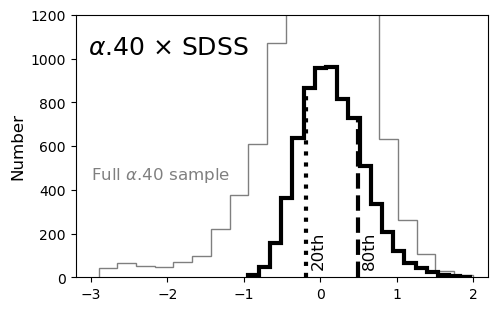

In [98]:

a40 = (pd.read_csv("../data/a40-SDSS_gas-frac.csv")
        .join(pd.read_csv("../data/a.40-delta_5.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_a40')
        .join(pd.read_csv("../data/a40.datafile3.csv", index_col="AGCNr"), on="AGCNr", rsuffix='_sdss')
)

plt.figure(figsize=(5, 3), dpi=100)

# parent sample
plt.hist(np.log10(pd.read_csv("../data/a.40-delta_5.csv").delta_5), histtype='step', bins=20, color='k', alpha=0.5)

a40 = a40[(a40.z_sdss < 0.05) & (a40.logfgas.notna()) & np.log10(a40.delta_5).notna()].copy()

# main plot
plt.hist(np.log10(a40.delta_5), bins=20, histtype='step', lw=3, color='k')

plt.vlines(np.quantile(np.log10(a40.delta_5), 0.2), 0, 860, ls=':', lw=3, color='k')
plt.vlines(np.quantile(np.log10(a40.delta_5), 0.8), 0, 720, ls='--', lw=3, color='k')

plt.text(-0.12, 50, '20th', fontsize=12, rotation=90)
plt.text(0.55, 50, '80th', fontsize=12, rotation=90)

plt.xlim(-3.2, 2.2)
plt.ylim(0, 1200)
plt.ylabel('Number', fontsize=12);


plt.text(0.03, 0.85, r'$\alpha$.40 $\times$ SDSS', transform=plt.gca().transAxes, fontsize=18)

plt.text(-3., 450, r'Full $\alpha$.40' + ' sample', c='k', fontsize=12, alpha=0.5)

plt.subplots_adjust(left=0.15, bottom=0.1, right=0.975, top=0.975)

plt.savefig(f'../results/figures/a40_delta_5.png')